In [2]:

import os
os.environ['NPY_PROMOTION_STATE'] = 'weak_and_warn'
import numpy as np
import warnings

# Ignore all warnings
warnings.simplefilter('ignore')

print('Hello, World!')
warnings.warn('This is a warning message')
print('No warnings displayed!')


Hello, World!
No warnings displayed!


# display original signal 

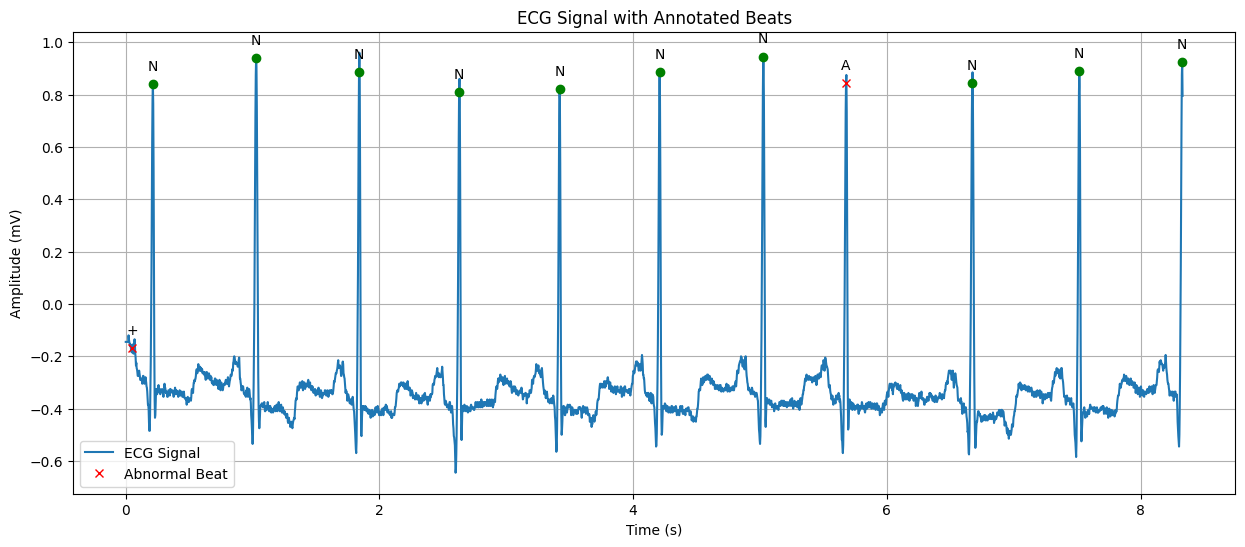

In [21]:
import wfdb
import matplotlib.pyplot as plt
import wfdb.processing

data_directory = 'mit-bih-arrhythmia-database-1.0.0/'
record_name = '100'
record = wfdb.rdrecord(f'{data_directory}{record_name}', sampto=3000)

# Read annotations
annotation = wfdb.rdann(f'{data_directory}{record_name}', 'atr')

fs = record.fs  # Sampling frequency
signal = record.p_signal[: , 0]  # Taking the first 5 seconds (first channel)
ecg_signal = (signal - np.mean(signal)) / np.std(signal)  # Normalization
time = [i / fs for i in range(len(signal))]
labels = annotation.symbol  # Labels for the annotations
r_peaks = annotation.sample

# Plot the ECG signal
plt.figure(figsize=(15, 6))
plt.plot(time, signal, label='ECG Signal')

for i, (sample, symbol) in enumerate(zip(annotation.sample, annotation.symbol)):
    if sample < len(signal):
        if symbol == 'N':  # Normal beat
            plt.plot(sample / fs, signal[sample], 'go', label='Normal Beat' if i == 0 else "")
            plt.annotate('N', (sample / fs, signal[sample]), textcoords="offset points", xytext=(0, 10), ha='center')
        else:  # Abnormal beat (e.g., 'A', 'V', etc.)
            plt.plot(sample / fs, signal[sample], 'rx', label='Abnormal Beat' if i == 0 else "")
            plt.annotate(symbol, (sample / fs, signal[sample]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('ECG Signal with Annotated Beats')
plt.legend(loc='best')
plt.grid()
plt.show()






# methode for filter the signal to clean the original signal 

In [4]:
import numpy as np
from scipy.ndimage import median_filter

def preprocess_signal(signal):
    y = np.zeros_like(signal)
    for n in range(12, len(signal)):
        y[n] = (1/18)*y[n-1] - (1/36)*y[n-2] + (1/36)*signal[n] - (1/18)*signal[n-6] + signal[n-12]
    filtered_signal_1 = median_filter(y, size=72)  # 200 ms median filter
    filtered_signal_2 = median_filter(y, size=216) # 600 ms median filter
    
    # Remove baseline drift
    baseline_drift = filtered_signal_2
    cleaned_signal = y - baseline_drift
    
    return cleaned_signal


# display the signal original and the siganl after execute filter custom methode

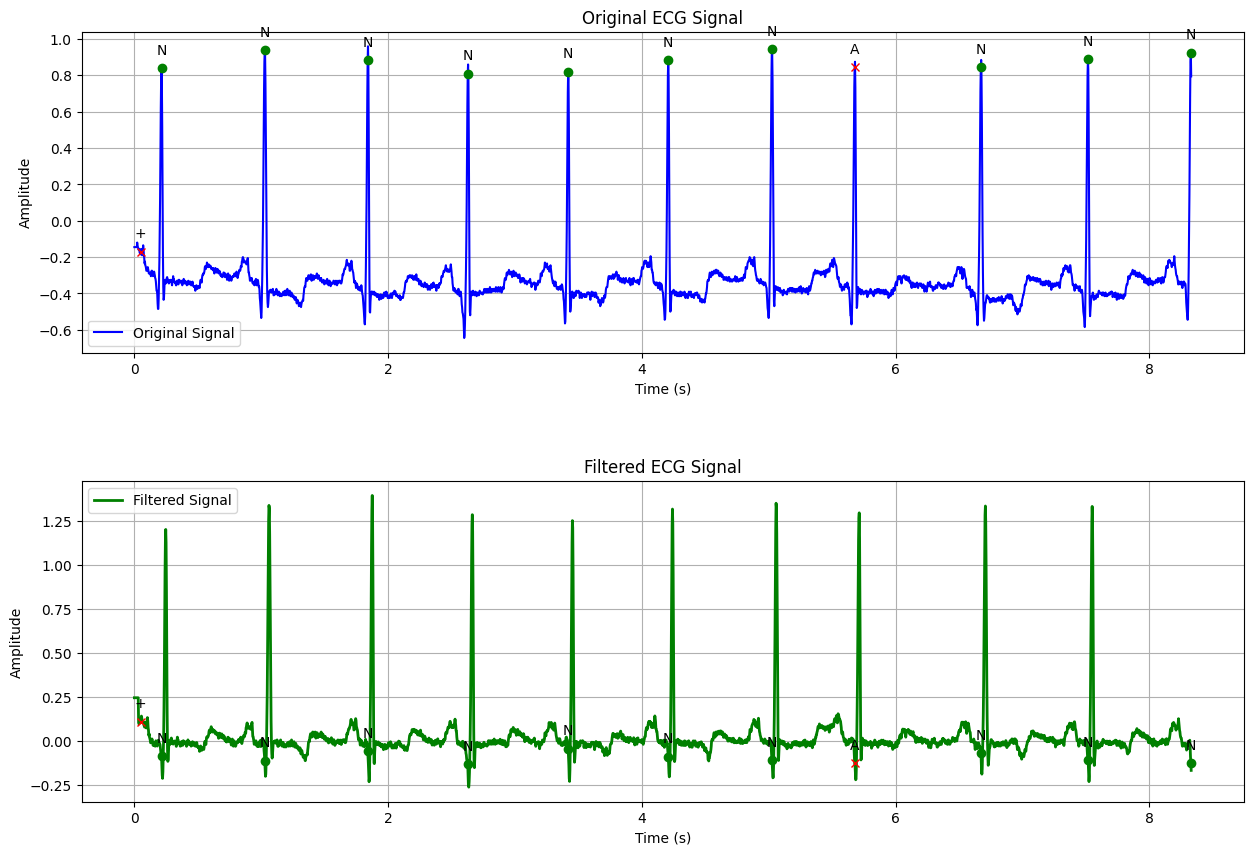

In [25]:

import numpy as np
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt

# Assume signal, fs, time, annotation, and custom_filter are defined

filtered_signal = preprocess_signal(signal)

plt.figure(figsize=(15, 10))

# Plot the original ECG signal
plt.subplot(2, 1, 1)
plt.plot(time, signal, 'b-', label='Original Signal')
plt.title('Original ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

# Annotate R-peaks on the original signal
for i, (sample, symbol) in enumerate(zip(annotation.sample, annotation.symbol)):
    if sample < len(signal):
        if symbol == 'N':  # Normal beat
            plt.plot(sample / fs, signal[sample], 'go', label='Normal Beat' if i == 0 else "")
            plt.annotate('N', (sample / fs, signal[sample]), textcoords="offset points", xytext=(0, 10), ha='center')
        else:  # Abnormal beat (e.g., 'A', 'V', etc.)
            plt.plot(sample / fs, signal[sample], 'rx', label='Abnormal Beat' if i == 0 else "")
            plt.annotate(symbol, (sample / fs, signal[sample]), textcoords="offset points", xytext=(0, 10), ha='center')

# Plot the filtered ECG signal
plt.subplot(2, 1, 2)
plt.plot(time, filtered_signal, 'g-', linewidth=2, label='Filtered Signal')
plt.title('Filtered ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

# Annotate R-peaks on the filtered signal
for i, (sample, symbol) in enumerate(zip(annotation.sample, annotation.symbol)):
    if sample < len(filtered_signal):
        if symbol == 'N':  # Normal beat
            plt.plot(sample / fs, filtered_signal[sample], 'go', label='Normal Beat' if i == 0 else "")
            plt.annotate('N', (sample / fs, filtered_signal[sample]), textcoords="offset points", xytext=(0, 10), ha='center')
        else:  # Abnormal beat (e.g., 'A', 'V', etc.)
            plt.plot(sample / fs, filtered_signal[sample], 'rx', label='Abnormal Beat' if i == 0 else "")
            plt.annotate(symbol, (sample / fs, filtered_signal[sample]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.subplots_adjust(hspace=0.4)  # Adjust the space between plots
plt.show()



# Heartbeat Annotations in Record 100
In record 100, we observe 1 heartbeat with a positive (+) annotation, 33 normal beats labeled as "A" and "N," a total of 2,239 normal beats, and 1 "V" annotation.

Annotations uniques et leur fréquence :
+: 1
A: 33
N: 2239
V: 1


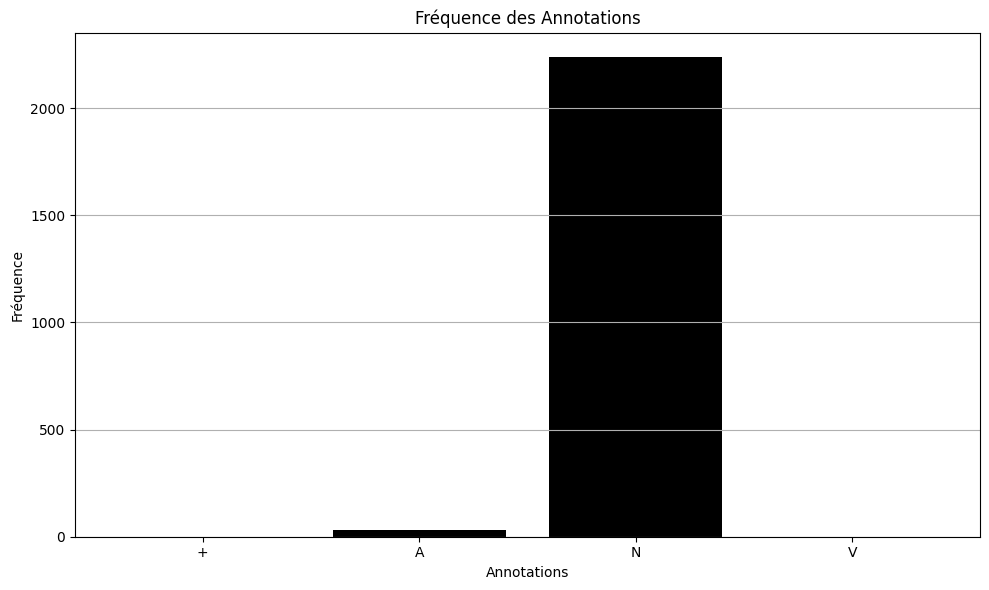

In [6]:
unique_annotations, counts = np.unique(annotation.symbol, return_counts=True)
print("Annotations uniques et leur fréquence :")
for annotation, count in zip(unique_annotations, counts):
    print(f"{annotation}: {count}")
plt.figure(figsize=(10, 6))
plt.bar(unique_annotations, counts, color='black')
plt.xlabel('Annotations')
plt.ylabel('Fréquence')
plt.title('Fréquence des Annotations')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Extracting RR Interval Features


In [8]:
def extract_rr_features(r_peaks, fs):
    """Extract RR interval features from R-peak indices."""
    
    rr_intervals = np.diff(r_peaks) / fs  # RR intervals
    post_rr = np.roll(rr_intervals, -1)[:-1]  # Post-RR intervals (shifted RR)
    
    rr_intervals_seconds = rr_intervals
    time_per_peak = np.cumsum(rr_intervals_seconds)
    
    rr_1min = rr_intervals_seconds[time_per_peak <= 60]
    rr_20min = rr_intervals_seconds[time_per_peak <= 1200]
    
    RR1 = np.mean(rr_1min) if len(rr_1min) > 0 else 0
    RR20 = np.mean(rr_20min) if len(rr_20min) > 0 else 0
    
    return [np.mean(rr_intervals), np.mean(post_rr), RR1, RR20]

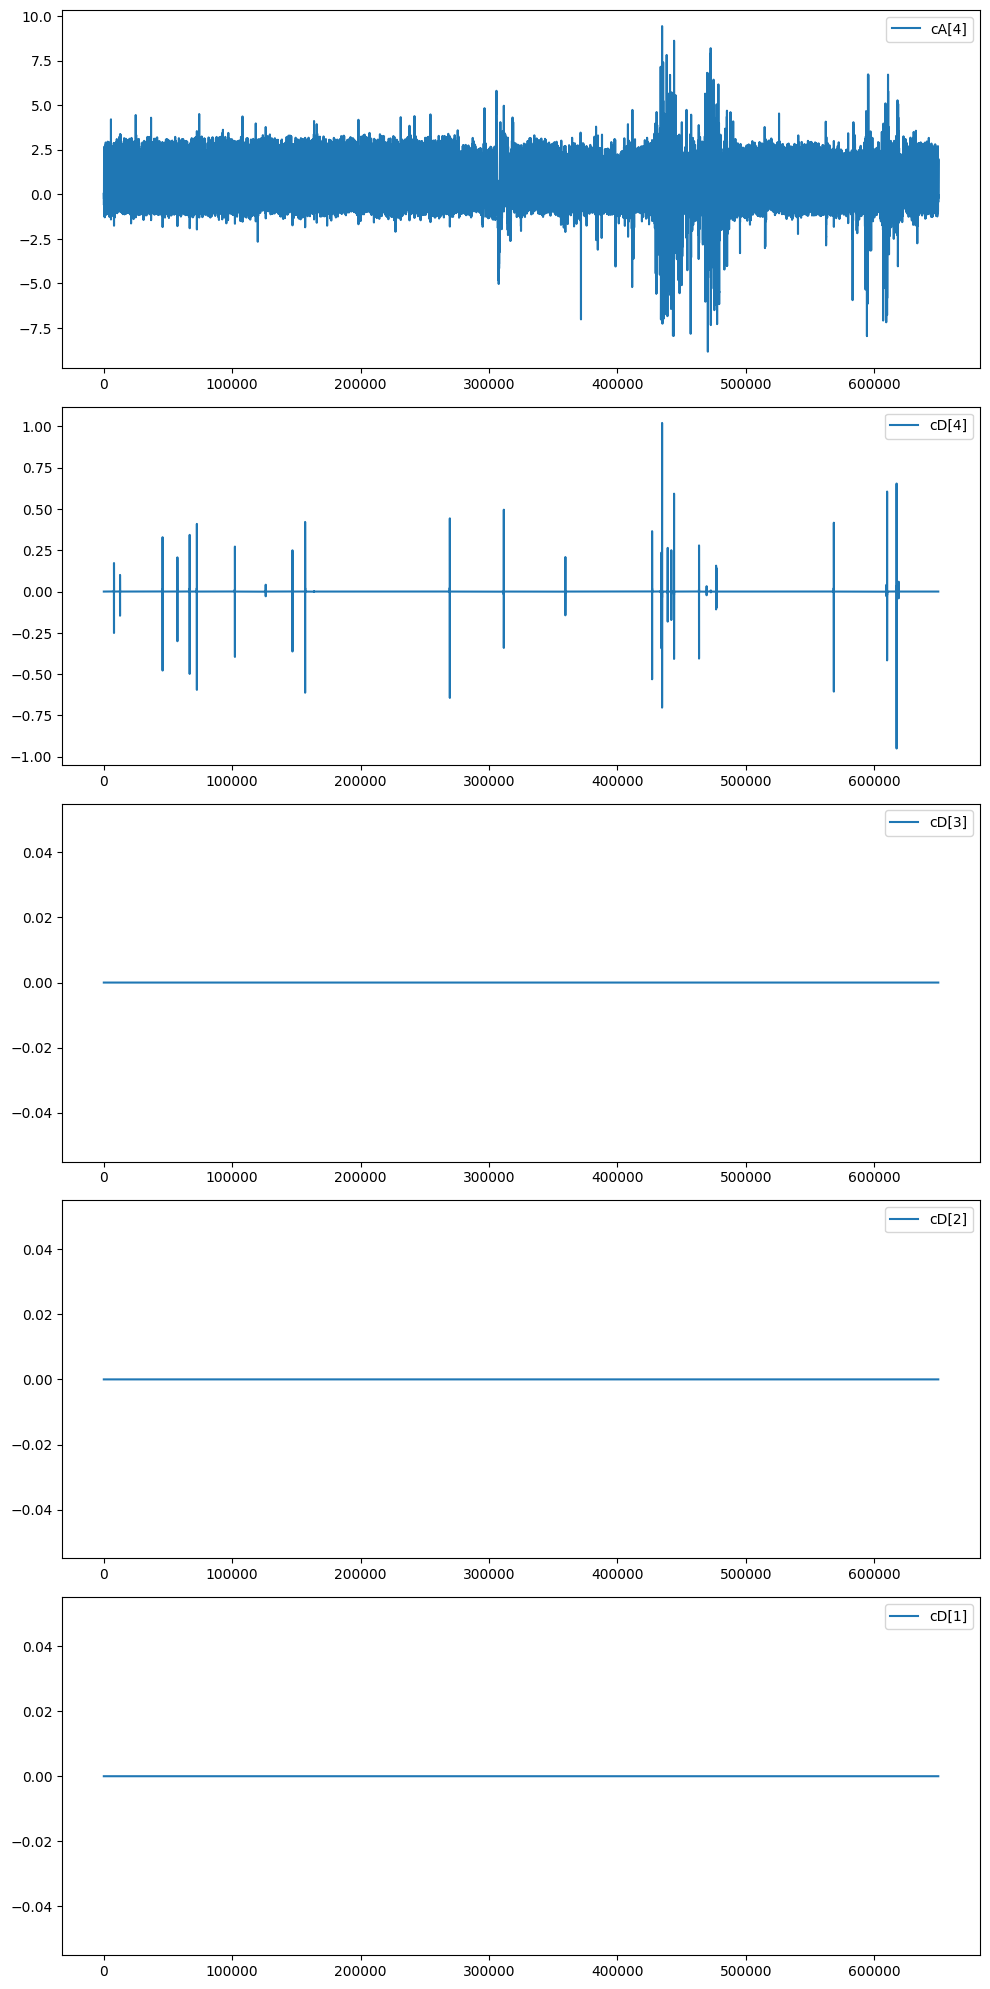

In [70]:

import copy
import pywt  # Import PyWavelets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def Wavelet(index_list, wavefunc='db4', lv=4, m=1, n=4, plot=False):
    '''
    WT: Wavelet Transformation Function
    index_list: Input Sequence;
    lv: Decomposing Level；
    wavefunc: Function of Wavelet, 'db4' default；
    m, n: Level of Threshold Processing
    '''
    # Decomposing
    coeff = pywt.wavedec(index_list, wavefunc, mode='sym', level=lv)  # Decompose by levels
    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0  # sgn function

    # Denoising
    for i in range(m, n + 1):  # Process levels m to n
        cD = coeff[i]
        Tr = np.sqrt(2 * np.log2(len(cD)))  # Compute threshold
        for j in range(len(cD)):
            if np.abs(cD[j]) >= Tr:
                coeff[i][j] = sgn(cD[j]) * (np.abs(cD[j]) - Tr)  # Shrink towards zero
            else:
                coeff[i][j] = 0  # Set to zero if below threshold

    # Reconstructing
    coeffs = {}
    for i in range(len(coeff)):
        coeffs[i] = copy.deepcopy(coeff)
        for j in range(len(coeff)):
            if j != i:
                coeffs[i][j] = np.zeros_like(coeff[j])  # Zero out all coefficients except for the ith level

    reconstructed_signals = []
    for i in range(len(coeff)):
        rec_signal = pywt.waverec(coeffs[i], wavefunc)
        if len(rec_signal) > len(index_list):
            rec_signal = rec_signal[:-1]
        reconstructed_signals.append(rec_signal)

    # Plotting the results
    if plot:
        fig, ax = plt.subplots(len(reconstructed_signals), 1, figsize=(10, 20))
        for i in range(len(reconstructed_signals)):
            if i == 0:
                ax[i].plot(reconstructed_signals[i], label=f'cA[{len(coeff) - i - 1}]')
            else:
                ax[i].plot(reconstructed_signals[i], label=f'cD[{len(coeff) - i}]')
            ax[i].legend(loc='best')
        plt.tight_layout()
        plt.show()

    return reconstructed_signals

# Usage
coeff = Wavelet(ecg_signal, plot=True)


In [71]:
coeff

[array([-0.54225267, -0.54203354, -0.54179091, ...,  1.55657887,
         1.75814998,  1.97115375]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

# Extract morphological features from the wavelet-transformed ECG signal

In [47]:
import pywt
import numpy as np
from scipy.stats import skew, kurtosis

def wavelet_decomposition(ecg_signal, wavelet='coif5', level=7):
    """
    Perform wavelet decomposition using a specified wavelet.
    """
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    return coeffs


def extract_wavelet_features(ecg_signal, r_peaks, fs):
    """
    Extract morphological features from the wavelet-transformed ECG signal.
    Parameters:
    - ecg_signal: numpy array of the ECG signal
    - r_peaks: list or array of R-peak indices
    - fs: sampling frequency of the ECG signal

    Returns:
    - wavelet_features: listsignal of tuples containing the first zero-crossing and max position
    """
    window_before_r_peak = int(0.13 * fs)  
    window_after_r_peak = int(0.2 * fs)    
    level = 4  # Decomposition level
    wavelet_features = []

    if len(ecg_signal) == 0 or len(r_peaks) == 0:
        return wavelet_features

    for r_peak in r_peaks:
        start_idx = max(0, r_peak - window_before_r_peak)
        end_idx = min(len(ecg_signal), r_peak + window_after_r_peak)

        ecg_segment = ecg_signal[start_idx:end_idx]

        if len(ecg_segment) < 2:
            continue
        coeffs = wavelet_decomposition(ecg_segment, level=level)

        # Use the fourth level detail coefficients (cD4) for feature extraction
        fourth_scale_signal = coeffs[-level]

        if len(fourth_scale_signal) < 2:
            continue

        mean_val = np.mean(fourth_scale_signal)
        variance = np.var(fourth_scale_signal)
        skewness = skew(fourth_scale_signal)
        kurt = kurtosis(fourth_scale_signal)

        # Store the extracted features
        wavelet_features.append((mean_val, variance, skewness, kurt))
    return wavelet_features


In [60]:
def apply_dwt(signal, wavelet='db4', level=4):
    """
    Appliquer la DWT au signal ECG.
    
    :param signal: Le signal ECG à décomposer.
    :param wavelet: Le type d'ondelette à utiliser.
    :param level: Le niveau de décomposition.
    :return: Coefficients d'ondelettes.
    """
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    return coeffs
np.mean(signal)


3000

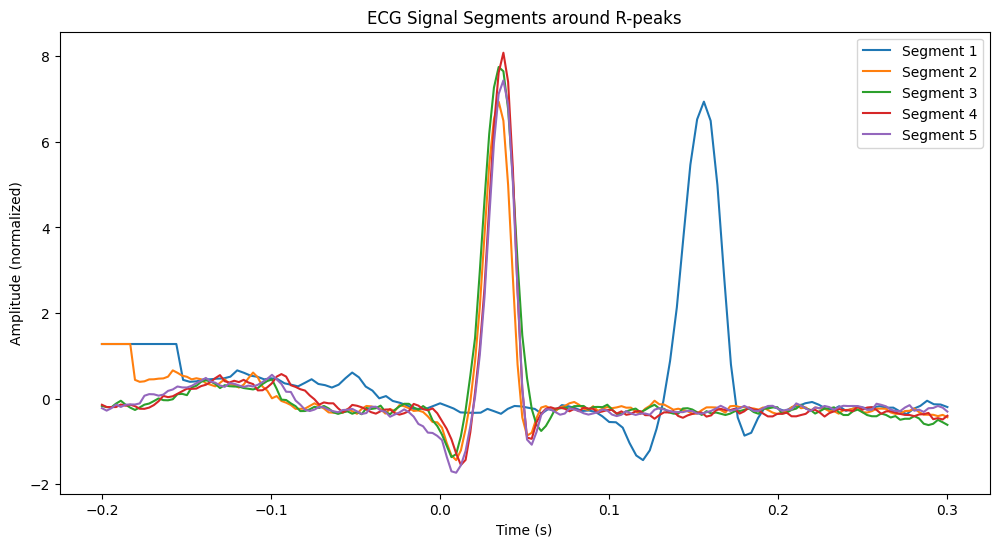

In [52]:

ecg_signal = (filtered_signal - np.mean(filtered_signal)) / np.std(filtered_signal)
def plot_ecg_segments(ecg_signal, r_peaks, fs, window_before=0.2, window_after=0.3):
    """
    Plot segmented ECG signals around R-peaks.
    """
    window_before_r_peak = int(window_before * fs)
    window_after_r_peak = int(window_after * fs)

    plt.figure(figsize=(12, 6))
    for idx, r_peak in enumerate(r_peaks[:5]):  # Plot first 5 segments
        start_idx = max(0, r_peak - window_before_r_peak)
        end_idx = min(len(ecg_signal), r_peak + window_after_r_peak)

        ecg_segment = ecg_signal[start_idx:end_idx]
        time_axis = np.linspace(-window_before, window_after, len(ecg_segment))

        plt.plot(time_axis, ecg_segment, label=f'Segment {idx + 1}')

    plt.title('ECG Signal Segments around R-peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (normalized)')
    plt.legend()
plot_ecg_segments(ecg_signal, r_peaks, fs)

# Collect and Preprocess the data 

In [73]:
import os
import wfdb
import numpy as np
from sklearn.preprocessing import LabelEncoder

all_features = []
all_labels = []
dataset_path =data_directory 
record_list = [f'{i:03}' for i in range(100, 106) if os.path.exists(dataset_path + f'{i:03}.dat')]
for record_name in record_list:
    record = wfdb.rdrecord(dataset_path + record_name)
    annotation = wfdb.rdann(dataset_path + record_name, 'atr')
    ecg_signal = record.p_signal[:, 0]
    ecg_signal = (ecg_signal - np.mean(ecg_signal)) / np.std(ecg_signal)  # Normalization
    r_peaks = annotation.sample
    fs = record.fs
    labels = annotation.symbol 
    for i, r_peak in enumerate(r_peaks[:-1]):
        features = extract_rr_features(r_peaks[i:i+2], fs)
        processed_signal = preprocess_signal(ecg_signal[r_peak:r_peaks[i+1]])
        signal_mean = np.mean(processed_signal)
        coeffs = pywt.wavedec(processed_signal, 'db4', level=4)
        cA = coeffs[0]
        cD = coeffs[1:]
        cA_mean = np.mean(cA)
        cA_std = np.std(cA)
        cD_mean = [np.mean(c) for c in cD]
        cD_std = [np.std(c) for c in cD]
        combined_features = features + [signal_mean, cA_mean, cA_std] + cD_mean + cD_std 
        
        all_features.append(combined_features)
        all_labels.append(labels[i])
X = np.array(all_features)
y = np.array(all_labels)

#label_encoder = LabelEncoder()
#y_encoded = label_encoder.fit_transform(y)



In [78]:
import pandas as pd
import numpy as np

features_df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
labels_series = pd.Series(y, name='target')
data_df = pd.concat([features_df, labels_series], axis=1)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,target
0,0.163889,NaN,0.163889,0.163889,0.094224,-0.267707,0.731603,0.093838,-0.016311,0.001451,0.010757,0.465868,0.140041,0.101782,0.067156,+
1,0.813889,NaN,0.813889,0.813889,0.084469,0.321176,1.217851,0.247755,-0.135292,-0.010945,0.010380,0.952305,0.927743,0.368610,0.261757,N
2,0.811111,NaN,0.811111,0.811111,0.107068,0.688706,1.829881,0.362002,-0.123787,-0.006344,0.015200,1.503409,0.947242,0.284394,0.273949,N
3,0.788889,NaN,0.788889,0.788889,0.124775,0.687008,1.914342,0.300670,-0.181707,-0.008945,0.016682,1.399100,1.192617,0.280104,0.256056,N
4,0.791667,NaN,0.791667,0.791667,0.123571,0.683229,1.557574,0.287395,-0.190127,-0.003913,0.007806,1.303757,1.121489,0.237769,0.240159,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13422,0.694444,NaN,0.694444,0.694444,0.083357,0.651606,1.689792,0.183358,-0.057411,-0.006660,0.009487,1.089183,0.298411,0.149340,0.159860,N
13423,0.677778,NaN,0.677778,0.677778,0.071554,0.483930,1.628866,0.206702,-0.069371,-0.007557,0.010113,1.154172,0.344991,0.145721,0.166624,N
13424,0.677778,NaN,0.677778,0.677778,0.110615,0.736186,1.709469,0.214972,-0.060749,-0.005630,0.010374,1.157608,0.309702,0.153455,0.164603,N
13425,0.694444,NaN,0.694444,0.694444,0.079728,0.761433,1.777921,0.182284,-0.062245,-0.007000,0.010619,1.012277,0.320890,0.146360,0.153316,N


In [94]:
# imputing with a constant

from sklearn.impute import SimpleImputer
train_constant = data_df.copy()
#setting strategy to 'constant' 
mean_imputer = SimpleImputer(strategy='constant') # imputing using constant value
train_constant.iloc[:,:] = mean_imputer.fit_transform(train_constant)
train_constant.isnull().sum()

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
target        0
dtype: int64

# Convert categorical features to numeric using label encoding


In [95]:
# Convert categorical features to numeric using label encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Apply label encoding to non-numeric columns
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = label_encoder.fit_transform(X[column])

are_all_numeric = X.apply(lambda x: pd.api.types.is_numeric_dtype(x)).all()
are_all_numeric

True

# Balance the dataset 

In [97]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
y = train_constant['target']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)
y_resampled_original = label_encoder.inverse_transform(y_resampled)


In [102]:
y_resampled

array([0, 3, 3, ..., 8, 8, 8])

# Comment
The results improved significantly after balancing the data using SMOTE for oversampling, but training time increased due to the larger dataset.

# train the model  Ensemble and use y_resampled_original as target 

In [99]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

imputer = SimpleImputer(strategy='mean') 
X_imputed = imputer.fit_transform(X_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_resampled_original, test_size=0.2, random_state=42)


lda_model = LinearDiscriminantAnalysis()

param_grid_knn = {'n_neighbors': np.arange(1, 20)}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_search_knn.fit(X_train, y_train)
best_knn = grid_search_knn.best_estimator_

svm_model = SVC(kernel='rbf', probability=True) 

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

voting_clf = VotingClassifier(estimators=[
    ('lda', lda_model), 
    ('knn', best_knn), 
    ('svm', svm_model), 
    ('rf', rf_model)
], voting='hard')  

voting_clf.fit(X_train, y_train)

y_pred_voting = voting_clf.predict(X_test)

print("Ensemble Model Performance (LDA + KNN + SVM + Random Forest):")
print(classification_report(y_test, y_pred_voting))



Ensemble Model Performance (LDA + KNN + SVM + Random Forest):
              precision    recall  f1-score   support

           +       0.97      1.00      0.98      1753
           /       0.92      1.00      0.96      1783
           A       0.99      1.00      1.00      1845
           N       0.99      0.96      0.98      1793
           Q       0.99      1.00      1.00      1808
           V       0.99      1.00      1.00      1771
           f       0.98      0.90      0.94      1816
           |       0.97      0.99      0.98      1783
           ~       1.00      0.94      0.97      1785

    accuracy                           0.98     16137
   macro avg       0.98      0.98      0.98     16137
weighted avg       0.98      0.98      0.98     16137



# Build AutoEncoder model 

In [105]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

class AutoEncoder(Model):
    def __init__(self, units):
        super(AutoEncoder, self).__init__()
        self.units = units

    def build(self, input_shape):
        # Define the encoder and decoder layers
        self.encoder = Dense(units=self.units, activation='relu')
        self.decoder = Dense(units=input_shape[-1], activation='sigmoid')  # Use sigmoid for reconstruction

    def call(self, X):
        Z = self.encoder(X)  # Encode the input
        return self.decoder(Z)  # Decode the encoded representation

    def encode(self, X):
        return self.encoder(X)  # Return the encoded representation

    def decode(self, Z):
        return self.decoder(Z)  # Decode the representation


# Integrate the AutoEncoder model and use y_resampled_original that have numeric label 

the accuarcy is even better now 

In [106]:
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer

# Assuming you have already preprocessed your dataset and have X_resampled and y_resampled_original
imputer = SimpleImputer(strategy='mean') 
X_imputed = imputer.fit_transform(X_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_resampled_original, test_size=0.2, random_state=42)

# Create and train the AutoEncoder
autoencoder = AutoEncoder(units=32)  # Change units as needed
autoencoder.build(input_shape=(X_train.shape[1],))  # Build the model
autoencoder.compile(optimizer='adam', loss='mse')  # Compile the model

autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

X_train_encoded = autoencoder.encode(X_train)
X_test_encoded = autoencoder.encode(X_test)

lda_model = LinearDiscriminantAnalysis()
best_knn = KNeighborsClassifier(n_neighbors=5)  # Use grid search for best parameters if needed
svm_model = SVC(kernel='rbf', probability=True) 
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

voting_clf = VotingClassifier(estimators=[
    ('lda', lda_model), 
    ('knn', best_knn), 
    ('svm', svm_model), 
    ('rf', rf_model)
], voting='hard')

voting_clf.fit(X_train_encoded, y_train)

# Predict and evaluate the ensemble model
y_pred_voting = voting_clf.predict(X_test_encoded)
print("Ensemble Model Performance (LDA + KNN + SVM + Random Forest):")
print(classification_report(y_test, y_pred_voting))


Epoch 1/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3735 - val_loss: 0.2913
Epoch 2/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3243 - val_loss: 0.2892
Epoch 3/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step - loss: 0.3375 - val_loss: 0.2888
Epoch 4/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 934us/step - loss: 0.3322 - val_loss: 0.2887
Epoch 5/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 992us/step - loss: 0.3224 - val_loss: 0.2886
Epoch 6/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3348 - val_loss: 0.2886
Epoch 7/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 952us/step - loss: 0.3215 - val_loss: 0.2886
Epoch 8/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3307 - val_loss: 0.2885
Epoch 9/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 967us/step - loss: 0.3320 - val_loss: 0.2885
Epoch 10/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 960us/step - loss: 0.3212 - val_loss: 0.2885
Epoch 11/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 926us/step - loss: 0.3189 - val_loss: 0.2885
Epoch 12/50
1614